# Census 2020 - Election 2020

In [12]:
import pandas as pd
import geopandas as gpd
import numpy
import sys


# Inputs
state = 'ia'
election_year = '2020'
census_year = '2020'

plot_dots = False
plot_precincts = False


In [13]:
process_voting_data(state, election_year, census_year, plot_dots = False, plot_precincts = False)

ia 2020 2020


<ipython-input-13-8221c8f16f6a>:1: DtypeWarning: Columns (29,31,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  process_voting_data(state, election_year, census_year, plot_dots = False, plot_precincts = False)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-11-193799e9d684>:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  df_b_with_precinct = gpd.sjoin(gdf_b, df_precincts[[name_col_precinct,'geometry']], how="inner")


Number of dictionary keys:  175194
Number of blocks:  175198
Number of missed blocks:  4


DriverError: cnty/ia_pl2020_cnty_shp/ia_pl2020_bg.shp: No such file or directory

In [14]:
def process_voting_data(state, election_year, census_year, plot_dots = False, plot_precincts = False):
    
    if plot_dots or plot_precincts:
        import matplotlib.pyplot as plt
        import random

    election_year_abv = election_year[-2:]
    census_year_abv = census_year[-2:]

    print(state, election_year, census_year)

    if election_year == '2016':
        election_vote_cols = ['G16PRERTRU','G16PREDCLI','G16PRELJOH']
    if election_year == '2020':
        election_vote_cols = ['G20PRERTRU','G20PREDBID','G20PRELJOR']

    rename_vote_cols = [f'R{election_year_abv}',f'D{election_year_abv}',f'L{election_year_abv}']

    if census_year == '2020':
        census_pop_col = 'P0010001'
        geoid_col = 'GEOID20'

    if census_year == '2010':
        print('error: code not prepared for 2010 census data extraction')


    # Input file names
    election_file = f'election_shp/{state}_vest_{election_year_abv}_shp/{state}_vest_{election_year_abv}.shp'
    cnty_file = f'cnty/{state}_pl{census_year}_cnty_shp/{state}_pl{census_year}_cnty.shp'
    tracts_file = f'tract/{state}_pl{census_year}_t_shp/{state}_pl{census_year}_t.shp'
    bg_file = f'bg2020/{state}_pl{census_year}_bg_shp/{state}_pl{census_year}_bg.shp'
    b_file = f'block_csv/{state}_pl{census_year}_b_csv/{state}_pl{census_year}_b.csv'


    #Outfiles
    b_outfile = f'{b_file[:-4]}_census_{census_year}_voter_{election_year}.csv'
    cnty_outfile = f'cnty/partisan_data/{state}_t_census_{census_year}_voter_data_{election_year}.csv'
    tract_outfile = f'tract/partisan_data/{state}_t_census_{census_year}_voter_data_{election_year}.csv'
    bg_outfile = f'bg2020/partisan_data/{state}_bg_census_{census_year}_voter_data_{election_year}.csv'  


    # Read precinct shapefile that has election data
    df_precincts = gpd.read_file(election_file)

    # Read block level csv file (omits the shapes, but as centroid lattitude and longitude)
    df_b = pd.read_csv(b_file, dtype = {geoid_col:'object'})


    #Create columns for block group and tract and county lavel
    df_b['bg'] = [geoid[:-3] for geoid in df_b[geoid_col]]
    df_b['t'] = [geoid[:-4] for  geoid in df_b[geoid_col]]

    #df_precincts.head()
    name_col_precinct = list(df_precincts.keys())[1]

    if name_col_precinct in df_b.keys():
        df_precincts = df_precincts.rename(columns = {name_col_precinct: name_col_precinct+'_PRECINCT'})
        name_col_precinct = name_col_precinct+'_PRECINCT'

    # The geometry of the precincts was in a different format, so we have to correct it with this line of code
    df_precincts = df_precincts.to_crs({'init': 'epsg:4326'})    


    # Create geopandas dataframe with geometry column as the centroid (that was provided in the csv file)
    gdf_b = gpd.GeoDataFrame(df_b, geometry=gpd.points_from_xy(df_b.INTPTLON, df_b.INTPTLAT))

    # Perform sjoin operation:
    ## Whenever centroid is in a precinct, label that block with the precint GEOID20 value
    df_b_with_precinct = gpd.sjoin(gdf_b, df_precincts[[name_col_precinct,'geometry']], how="inner")


    # Make a map from precinct to list of blocks in the precinct
    d = {index : [] for index in df_precincts.index}
    for i in list(df_b_with_precinct.index):
        index = df_b_with_precinct['index_right'][i]
        if type(index) == numpy.int64:
            d[index] = d[index] + [i]

    dkeys = sum([len(d[i]) for i in d.keys()])
    num_precincts = len(df_b_with_precinct)
    print("Number of dictionary keys: ", dkeys)
    print("Number of blocks: ", num_precincts)
    print("Number of missed blocks: ",  num_precincts - dkeys)

    if dkeys/num_precincts < 0.97:
        print("Possible error!  Check to make sure that mapping worked.")
        sys.exit()


    # Disaggregate election data from precincts to blocks

    n = len(df_b_with_precinct)

    # Create columns for election data 
    for col in rename_vote_cols:
        df_b_with_precinct[col] = [0 for _ in range(n)]


    #def disaggregate_vote(precinct):
    for i in df_precincts.index:
        votes = [df_precincts[col][i] for col in election_vote_cols]
        POP_total = sum(df_b_with_precinct[census_pop_col][d[i]])

        # Prevent divide by 0 errors
        if POP_total > 0:
            for j in d[i]:
                ratio = float(df_b_with_precinct[census_pop_col][j]/POP_total)
                for k in range(len(election_vote_cols)):
                    df_b_with_precinct.loc[j, rename_vote_cols[k]] = votes[k]*ratio

        # Case where population in the precinct seems to be 0
        else:
            for j in d[i]:
                for k in range(len(election_vote_cols)):
                    df_b_with_precinct.loc[j, rename_vote_cols[k]] = 0

    # Write updated block csv file
    df_b_with_precinct.to_csv(b_outfile)

    # Aggregate voter data to block groups

    # Read block group shape file
    df_bg = gpd.read_file(bg_file)

    # Aggregate votes from blocks to block groups
    for col in rename_vote_cols:
        df_bg[col] = [sum(df_b_with_precinct[df_b_with_precinct['bg']==bg][col]) for bg in df_bg[geoid_col]]

    # Write block group data to a file      
    cols = ['GEOID'] + ['GEOID20'] + rename_vote_cols
    df_bg[cols].to_csv(bg_outfile)    


    # Aggregate voter data to tracts

    # Read tract shapefile
    df_tracts = gpd.read_file(tracts_file)

    # Aggregate votes from blocks to tracts
    for col in rename_vote_cols:
        df_tracts[col] = [sum(df_b_with_precinct[df_b_with_precinct['t']==tract][col]) for tract in df_tracts[geoid_col]]

    # Write tract data to a file  
    cols = ['GEOID'] + ['GEOID20'] + rename_vote_cols
    
    
    df_tracts[cols].to_csv(cnty_outfile)    
    
    
    result = df_b_with_precinct.groupby('COUNTY')[census_cols].aggregate('sum')
    result.to_csv(cnty_outfile)
    

    # Sanity check
    a = [sum(df_tracts[col]) for col in rename_vote_cols]
    b = [sum(df_bg[col]) for col in rename_vote_cols]
    c = [sum(df_precincts[col]) for col in election_vote_cols]
    d = [sum(df_cnty[col]) for col in rename_vote_cols]

    print("county Totals:",d)
    print("tract Totals:",a)
    print("bg Totals:", b)
    print("Desired Totals:", c)
    print("Cnty ratio: ", [d[i]/c[i] for i in range(len(rename_vote_cols))])
    print("Tract ratio: ", [a[i]/c[i] for i in range(len(rename_vote_cols))])
    print("bg ratio:    ", [b[i]/c[i] for i in range(len(rename_vote_cols))])

    if min([a[i]/c[i] for i in range(len(rename_vote_cols))]) < 0.97:
        print("Error: Did not count enough votes at tract level")
        sys.exit()
    if min([b[i]/c[i] for i in range(len(rename_vote_cols))]) < 0.97:
        print("Error: Did not count enough votes at bg level")
        sys.exit()


    if plot_dots:
        fig, ax = plt.subplots(1,figsize=(25,25))
        plt.figure(figsize=(100,150))


        for i in range(200):
            geoid = df_precincts[name_col_precinct][i]
            color="#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])

            df_precincts[df_precincts[name_col_precinct]==geoid].plot(ax = ax, facecolor = 'yellow', alpha=0.5, edgecolor = 'green')
            df_b_with_precinct[df_b_with_precinct[name_col_precinct]==geoid].plot(ax = ax,  c = color)
        plt.show()
    if plot_precincts:
        df_precincts.plot( facecolor = 'yellow', alpha=0.5, edgecolor = 'green')
        plt.show()

# County aggregation

In [76]:
import pandas as pd
import geopandas as gpd
import numpy
import sys


# Inputs
state = 'ia'
election_year = '2016'
census_year = '2020'

plot_dots = False
plot_precincts = False



election_year_abv = election_year[-2:]
census_year_abv = census_year[-2:]

print(state, election_year, census_year)

if election_year == '2016':
    election_vote_cols = ['G16PRERTRU','G16PREDCLI','G16PRELJOH']
    census_cols = census_cols16
if election_year == '2020':
    election_vote_cols = ['G20PRERTRU','G20PREDBID','G20PRELJOR']
    census_cols = census_cols20

rename_vote_cols = [f'R{election_year_abv}',f'D{election_year_abv}',f'L{election_year_abv}']

if census_year == '2020':
    census_pop_col = 'P0010001'
    geoid_col = 'GEOID20'

if census_year == '2010':
    print('error: code not prepared for 2010 census data extraction')


b_file = f'block_csv/{state}_pl{census_year}_b_csv/{state}_pl{census_year}_b.csv'

cnty_outfile = f'cnty/partisan_data/{state}_cnty_census_{census_year}_voter_data_{election_year}.csv'
cnty_file = f'cnty/{state}_pl{census_year}_cnty_shp/{state}_pl{census_year}_cnty.shp'
b_outfile = f'{b_file[:-4]}_census_{census_year}_voter_{election_year}.csv'
df_b_with_precinct_file = b_outfile


df_b_with_precinct = pd.read_csv(df_b_with_precinct_file, dtype = {'COUNTY': str})


election_file = f'election_shp/{state}_vest_{election_year_abv}_shp/{state}_vest_{election_year_abv}.shp'




b_file = f'block_csv/{state}_pl{census_year}_b_csv/{state}_pl{census_year}_b.csv'

cnty_outfile = f'cnty/partisan_data/{state}_cnty_census_{census_year}_voter_data_{election_year}.csv'
cnty_file = f'cnty/{state}_pl{census_year}_cnty_shp/{state}_pl{census_year}_cnty.shp'
b_outfile = f'{b_file[:-4]}_census_{census_year}_voter_{election_year}.csv'
df_b_with_precinct_file = b_outfile


df_b_with_precinct = pd.read_csv(df_b_with_precinct_file, dtype = {'COUNTY': str})


result = df_b_with_precinct.groupby('COUNTY')[census_cols].aggregate('sum')
result.to_csv(cnty_outfile)
print("Done!")

ia 2016 2020
Done!


In [71]:
b_outfile

'block_csv/ia_pl2020_b_csv/ia_pl2020_b_census_2020_voter_2016.csv'

In [72]:
df_b_with_precinct.keys

,Unnamed: 0,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,...,P0050010,bg,t,cnty,geometry,index_right,DISTRICT,R16,D16,L16
0,0,PLST,IA,750,0,0,0,72093,7500000US190019601001000,190019601001000,...,0,190019601001,19001960100,19001960100,POINT (-94.2512136 41.4984878),503,2NE,3.082656,1.693767,0.176152
1,1,PLST,IA,750,0,0,0,72094,7500000US190019601001001,190019601001001,...,0,190019601001,19001960100,19001960100,POINT (-94.2692038 41.4999655),503,2NE,0.000000,0.000000,0.000000
2,2,PLST,IA,750,0,0,0,72095,7500000US190019601001002,190019601001002,...,0,190019601001,19001960100,19001960100,POINT (-94.2777478 41.5018382),503,2NE,0.000000,0.000000,0.000000
3,3,PLST,IA,750,0,0,0,72096,7500000US190019601001003,190019601001003,...,0,190019601001,19001960100,19001960100,POINT (-94.2887058 41.5011934),503,2NE,1.233062,0.677507,0.070461
4,4,PLST,IA,750,0,0,0,72097,7500000US190019601001004,190019601001004,...,0,190019601001,19001960100,19001960100,POINT (-94.3030883 41.5026932),503,2NE,1.233062,0.677507,0.070461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175193,175086,PLST,IA,750,0,0,0,247179,7500000US191976805002038,191976805002038,...,0,191976805002,19197680500,19197680500,POINT (-93.9052265 42.6657212),293,EGWARD4,3.565032,1.944563,0.204691
175194,175091,PLST,IA,750,0,0,0,247184,7500000US191976805002043,191976805002043,...,0,191976805002,19197680500,19197680500,POINT (-93.90961799999999 42.6646358),293,EGWARD4,6.907249,3.767591,0.396588
175195,175092,PLST,IA,750,0,0,0,247185,7500000US191976805002044,191976805002044,...,0,191976805002,19197680500,19197680500,POINT (-93.9110357 42.6646326),293,EGWARD4,4.901919,2.673774,0.281450
175196,175093,PLST,IA,750,0,0,0,247186,7500000US191976805002045,191976805002045,...,0,191976805002,19197680500,19197680500,POINT (-93.90622740000001 42.6749798),293,EGWARD4,0.000000,0.000000,0.000000


# Other stuff

In [59]:
election_file = f'election_shp/{state}_vest_{election_year_abv}_shp/{state}_vest_{election_year_abv}.shp'



# Read precinct shapefile that has election data
df_precincts = gpd.read_file(election_file)


election_year_abv = election_year[-2:]
census_year_abv = census_year[-2:]

print(state, election_year, census_year)

if election_year == '2016':
    election_vote_cols = ['G16PRERTRU','G16PREDCLI','G16PRELJOH']
if election_year == '2020':
    election_vote_cols = ['G20PRERTRU','G20PREDBID','G20PRELJOR']

rename_vote_cols = [f'R{election_year_abv}',f'D{election_year_abv}',f'L{election_year_abv}']

if census_year == '2020':
    census_pop_col = 'P0010001'
    geoid_col = 'GEOID20'

if census_year == '2010':
    print('error: code not prepared for 2010 census data extraction')


b_file = f'block_csv/{state}_pl{census_year}_b_csv/{state}_pl{census_year}_b.csv'

cnty_outfile = f'cnty/partisan_data/{state}_cnty_census_{census_year}_voter_data_{election_year}.csv'
cnty_file = f'cnty/{state}_pl{census_year}_cnty_shp/{state}_pl{census_year}_cnty.shp'
b_outfile = f'{b_file[:-4]}_census_{census_year}_voter_{election_year}.csv'
df_b_with_precinct_file = b_outfile


df_b_with_precinct = pd.read_csv(df_b_with_precinct_file, dtype = {'COUNTY': str})


ia 2020 2020


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (30,32,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [60]:
df_b_with_precinct['COUNTY']

0           1
1           1
2           1
3           1
4           1
         ... 
175193    197
175194    197
175195    197
175196    197
175197    197
Name: COUNTY, Length: 175198, dtype: object

In [75]:
election_file = f'election_shp/{state}_vest_{election_year_abv}_shp/{state}_vest_{election_year_abv}.shp'



# Read precinct shapefile that has election data
df_precincts = gpd.read_file(election_file)


election_year_abv = election_year[-2:]
census_year_abv = census_year[-2:]

print(state, election_year, census_year)

if election_year == '2016':
    election_vote_cols = ['G16PRERTRU','G16PREDCLI','G16PRELJOH']
    census_cols = census_cols16
if election_year == '2020':
    election_vote_cols = ['G20PRERTRU','G20PREDBID','G20PRELJOR']
    census_cols = census_cols20

rename_vote_cols = [f'R{election_year_abv}',f'D{election_year_abv}',f'L{election_year_abv}']

if census_year == '2020':
    census_pop_col = 'P0010001'
    geoid_col = 'GEOID20'

if census_year == '2010':
    print('error: code not prepared for 2010 census data extraction')


b_file = f'block_csv/{state}_pl{census_year}_b_csv/{state}_pl{census_year}_b.csv'

cnty_outfile = f'cnty/partisan_data/{state}_cnty_census_{census_year}_voter_data_{election_year}.csv'
cnty_file = f'cnty/{state}_pl{census_year}_cnty_shp/{state}_pl{census_year}_cnty.shp'
b_outfile = f'{b_file[:-4]}_census_{census_year}_voter_{election_year}.csv'
df_b_with_precinct_file = b_outfile


df_b_with_precinct = pd.read_csv(df_b_with_precinct_file)



# Write cnty data to a file  
cols = ['GEOID'] + ['GEOID20'] + rename_vote_cols
df_cnty[cols].to_csv(cnty_outfile) 


# Sanity check
c = [sum(df_precincts[col]) for col in election_vote_cols]

d = [sum(df_cnty[col]) for col in rename_vote_cols]

print("county Totals:",d)

print("Desired Totals:", c)
print("Cnty ratio: ", [d[i]/c[i] for i in range(len(rename_vote_cols))])


ia 2016 2020


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (30,32,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyError: "['R16', 'D16', 'L16'] not in index"

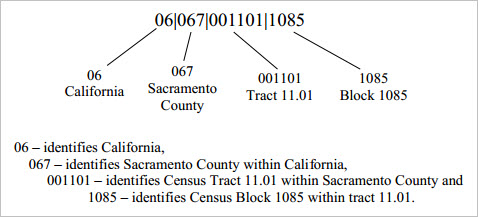

In [30]:
list(df_b_with_precinct.keys())

['Unnamed: 0',
 'FILEID',
 'STUSAB',
 'SUMLEV',
 'GEOVAR',
 'GEOCOMP',
 'CHARITER',
 'LOGRECNO',
 'GEOID',
 'GEOCODE',
 'REGION',
 'DIVISION',
 'STATE',
 'STATENS',
 'COUNTY',
 'COUNTYCC',
 'COUNTYNS',
 'COUSUB',
 'COUSUBCC',
 'COUSUBNS',
 'CONCIT',
 'CONCITCC',
 'CONCITNS',
 'PLACE',
 'PLACECC',
 'PLACENS',
 'TRACT',
 'BLKGRP',
 'BLOCK',
 'AIANHH',
 'AIHHTLI',
 'AIANHHFP',
 'AIANHHCC',
 'AIANHHNS',
 'AITS',
 'AITSFP',
 'AITSCC',
 'AITSNS',
 'TTRACT',
 'TBLKGRP',
 'ANRC',
 'ANRCCC',
 'ANRCNS',
 'CBSA',
 'MEMI',
 'CSA',
 'METDIV',
 'NECTA',
 'NMEMI',
 'CNECTA',
 'NECTADIV',
 'CBSAPCI',
 'NECTAPCI',
 'CD116',
 'SLDU18',
 'SLDL18',
 'VTD',
 'VTDI',
 'SDELM',
 'SDSEC',
 'SDUNI',
 'AREALAND',
 'AREAWATR',
 'BASENAME',
 'NAME',
 'FUNCSTAT',
 'POP100',
 'HU100',
 'INTPTLAT',
 'INTPTLON',
 'LSADC',
 'UGA',
 'GEOID20',
 'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P001001

In [46]:
df_b_with_precinct.COUNTY = df_b_with_precinct.COUNTY.astype('int64')
counties = set(df_b_with_precinct.COUNTY)

In [47]:
len(counties)

99

In [48]:
print(counties)

{1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197}


In [49]:
print(set(df_cnty['COUNTY']))

{1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197}


In [44]:
len(counties)

99

In [50]:
counties.difference(set(df_cnty['COUNTY']))

set()

In [38]:
df_cnty['COUNTY'] = df_cnty.COUNTY.astype('int64')
df_cnty['COUNTY']

0     197
1     137
2     175
3     107
4     169
     ... 
94    125
95    123
96      7
97    177
98    103
Name: COUNTY, Length: 99, dtype: int64

In [64]:
df_b_with_precinct['GEOID'][]

0         7500000US190019601001000
1         7500000US190019601001001
2         7500000US190019601001002
3         7500000US190019601001003
4         7500000US190019601001004
                    ...           
175193    7500000US191976805002038
175194    7500000US191976805002043
175195    7500000US191976805002044
175196    7500000US191976805002045
175197    7500000US191976805002046
Name: GEOID, Length: 175198, dtype: object

In [28]:
df_cnty['GEOID']

0     0500000US19197
1     0500000US19137
2     0500000US19175
3     0500000US19107
4     0500000US19169
           ...      
94    0500000US19125
95    0500000US19123
96    0500000US19007
97    0500000US19177
98    0500000US19103
Name: GEOID, Length: 99, dtype: object

In [53]:
list(df_b_with_precinct.keys())

['Unnamed: 0',
 'FILEID',
 'STUSAB',
 'SUMLEV',
 'GEOVAR',
 'GEOCOMP',
 'CHARITER',
 'LOGRECNO',
 'GEOID',
 'GEOCODE',
 'REGION',
 'DIVISION',
 'STATE',
 'STATENS',
 'COUNTY',
 'COUNTYCC',
 'COUNTYNS',
 'COUSUB',
 'COUSUBCC',
 'COUSUBNS',
 'CONCIT',
 'CONCITCC',
 'CONCITNS',
 'PLACE',
 'PLACECC',
 'PLACENS',
 'TRACT',
 'BLKGRP',
 'BLOCK',
 'AIANHH',
 'AIHHTLI',
 'AIANHHFP',
 'AIANHHCC',
 'AIANHHNS',
 'AITS',
 'AITSFP',
 'AITSCC',
 'AITSNS',
 'TTRACT',
 'TBLKGRP',
 'ANRC',
 'ANRCCC',
 'ANRCNS',
 'CBSA',
 'MEMI',
 'CSA',
 'METDIV',
 'NECTA',
 'NMEMI',
 'CNECTA',
 'NECTADIV',
 'CBSAPCI',
 'NECTAPCI',
 'CD116',
 'SLDU18',
 'SLDL18',
 'VTD',
 'VTDI',
 'SDELM',
 'SDSEC',
 'SDUNI',
 'AREALAND',
 'AREAWATR',
 'BASENAME',
 'NAME',
 'FUNCSTAT',
 'POP100',
 'HU100',
 'INTPTLAT',
 'INTPTLON',
 'LSADC',
 'UGA',
 'GEOID20',
 'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P001001

In [54]:
 census_cols20 = ['R20',
 'D20',
 'L20', 
'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P0010014',
 'P0010015',
 'P0010016',
 'P0010017',
 'P0010018',
 'P0010019',
 'P0010020',
 'P0010021',
 'P0010022',
 'P0010023',
 'P0010024',
 'P0010025',
 'P0010026',
 'P0010027',
 'P0010028',
 'P0010029',
 'P0010030',
 'P0010031',
 'P0010032',
 'P0010033',
 'P0010034',
 'P0010035',
 'P0010036',
 'P0010037',
 'P0010038',
 'P0010039',
 'P0010040',
 'P0010041',
 'P0010042',
 'P0010043',
 'P0010044',
 'P0010045',
 'P0010046',
 'P0010047',
 'P0010048',
 'P0010049',
 'P0010050',
 'P0010051',
 'P0010052',
 'P0010053',
 'P0010054',
 'P0010055',
 'P0010056',
 'P0010057',
 'P0010058',
 'P0010059',
 'P0010060',
 'P0010061',
 'P0010062',
 'P0010063',
 'P0010064',
 'P0010065',
 'P0010066',
 'P0010067',
 'P0010068',
 'P0010069',
 'P0010070',
 'P0010071',
 'P0020001',
 'P0020002',
 'P0020003',
 'P0020004',
 'P0020005',
 'P0020006',
 'P0020007',
 'P0020008',
 'P0020009',
 'P0020010',
 'P0020011',
 'P0020012',
 'P0020013',
 'P0020014',
 'P0020015',
 'P0020016',
 'P0020017',
 'P0020018',
 'P0020019',
 'P0020020',
 'P0020021',
 'P0020022',
 'P0020023',
 'P0020024',
 'P0020025',
 'P0020026',
 'P0020027',
 'P0020028',
 'P0020029',
 'P0020030',
 'P0020031',
 'P0020032',
 'P0020033',
 'P0020034',
 'P0020035',
 'P0020036',
 'P0020037',
 'P0020038',
 'P0020039',
 'P0020040',
 'P0020041',
 'P0020042',
 'P0020043',
 'P0020044',
 'P0020045',
 'P0020046',
 'P0020047',
 'P0020048',
 'P0020049',
 'P0020050',
 'P0020051',
 'P0020052',
 'P0020053',
 'P0020054',
 'P0020055',
 'P0020056',
 'P0020057',
 'P0020058',
 'P0020059',
 'P0020060',
 'P0020061',
 'P0020062',
 'P0020063',
 'P0020064',
 'P0020065',
 'P0020066',
 'P0020067',
 'P0020068',
 'P0020069',
 'P0020070',
 'P0020071',
 'P0020072',
 'P0020073',
 'P0030001',
 'P0030002',
 'P0030003',
 'P0030004',
 'P0030005',
 'P0030006',
 'P0030007',
 'P0030008',
 'P0030009',
 'P0030010',
 'P0030011',
 'P0030012',
 'P0030013',
 'P0030014',
 'P0030015',
 'P0030016',
 'P0030017',
 'P0030018',
 'P0030019',
 'P0030020',
 'P0030021',
 'P0030022',
 'P0030023',
 'P0030024',
 'P0030025',
 'P0030026',
 'P0030027',
 'P0030028',
 'P0030029',
 'P0030030',
 'P0030031',
 'P0030032',
 'P0030033',
 'P0030034',
 'P0030035',
 'P0030036',
 'P0030037',
 'P0030038',
 'P0030039',
 'P0030040',
 'P0030041',
 'P0030042',
 'P0030043',
 'P0030044',
 'P0030045',
 'P0030046',
 'P0030047',
 'P0030048',
 'P0030049',
 'P0030050',
 'P0030051',
 'P0030052',
 'P0030053',
 'P0030054',
 'P0030055',
 'P0030056',
 'P0030057',
 'P0030058',
 'P0030059',
 'P0030060',
 'P0030061',
 'P0030062',
 'P0030063',
 'P0030064',
 'P0030065',
 'P0030066',
 'P0030067',
 'P0030068',
 'P0030069',
 'P0030070',
 'P0030071',
 'P0040001',
 'P0040002',
 'P0040003',
 'P0040004',
 'P0040005',
 'P0040006',
 'P0040007',
 'P0040008',
 'P0040009',
 'P0040010',
 'P0040011',
 'P0040012',
 'P0040013',
 'P0040014',
 'P0040015',
 'P0040016',
 'P0040017',
 'P0040018',
 'P0040019',
 'P0040020',
 'P0040021',
 'P0040022',
 'P0040023',
 'P0040024',
 'P0040025',
 'P0040026',
 'P0040027',
 'P0040028',
 'P0040029',
 'P0040030',
 'P0040031',
 'P0040032',
 'P0040033',
 'P0040034',
 'P0040035',
 'P0040036',
 'P0040037',
 'P0040038',
 'P0040039',
 'P0040040',
 'P0040041',
 'P0040042',
 'P0040043',
 'P0040044',
 'P0040045',
 'P0040046',
 'P0040047',
 'P0040048',
 'P0040049',
 'P0040050',
 'P0040051',
 'P0040052',
 'P0040053',
 'P0040054',
 'P0040055',
 'P0040056',
 'P0040057',
 'P0040058',
 'P0040059',
 'P0040060',
 'P0040061',
 'P0040062',
 'P0040063',
 'P0040064',
 'P0040065',
 'P0040066',
 'P0040067',
 'P0040068',
 'P0040069',
 'P0040070',
 'P0040071',
 'P0040072',
 'P0040073',
 'H0010001',
 'H0010002',
 'H0010003',
 'P0050001',
 'P0050002',
 'P0050003',
 'P0050004',
 'P0050005',
 'P0050006',
 'P0050007',
 'P0050008',
 'P0050009',
 'P0050010']

In [74]:
census_cols16 = ['R16',
 'D16',
 'L16', 
'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P0010014',
 'P0010015',
 'P0010016',
 'P0010017',
 'P0010018',
 'P0010019',
 'P0010020',
 'P0010021',
 'P0010022',
 'P0010023',
 'P0010024',
 'P0010025',
 'P0010026',
 'P0010027',
 'P0010028',
 'P0010029',
 'P0010030',
 'P0010031',
 'P0010032',
 'P0010033',
 'P0010034',
 'P0010035',
 'P0010036',
 'P0010037',
 'P0010038',
 'P0010039',
 'P0010040',
 'P0010041',
 'P0010042',
 'P0010043',
 'P0010044',
 'P0010045',
 'P0010046',
 'P0010047',
 'P0010048',
 'P0010049',
 'P0010050',
 'P0010051',
 'P0010052',
 'P0010053',
 'P0010054',
 'P0010055',
 'P0010056',
 'P0010057',
 'P0010058',
 'P0010059',
 'P0010060',
 'P0010061',
 'P0010062',
 'P0010063',
 'P0010064',
 'P0010065',
 'P0010066',
 'P0010067',
 'P0010068',
 'P0010069',
 'P0010070',
 'P0010071',
 'P0020001',
 'P0020002',
 'P0020003',
 'P0020004',
 'P0020005',
 'P0020006',
 'P0020007',
 'P0020008',
 'P0020009',
 'P0020010',
 'P0020011',
 'P0020012',
 'P0020013',
 'P0020014',
 'P0020015',
 'P0020016',
 'P0020017',
 'P0020018',
 'P0020019',
 'P0020020',
 'P0020021',
 'P0020022',
 'P0020023',
 'P0020024',
 'P0020025',
 'P0020026',
 'P0020027',
 'P0020028',
 'P0020029',
 'P0020030',
 'P0020031',
 'P0020032',
 'P0020033',
 'P0020034',
 'P0020035',
 'P0020036',
 'P0020037',
 'P0020038',
 'P0020039',
 'P0020040',
 'P0020041',
 'P0020042',
 'P0020043',
 'P0020044',
 'P0020045',
 'P0020046',
 'P0020047',
 'P0020048',
 'P0020049',
 'P0020050',
 'P0020051',
 'P0020052',
 'P0020053',
 'P0020054',
 'P0020055',
 'P0020056',
 'P0020057',
 'P0020058',
 'P0020059',
 'P0020060',
 'P0020061',
 'P0020062',
 'P0020063',
 'P0020064',
 'P0020065',
 'P0020066',
 'P0020067',
 'P0020068',
 'P0020069',
 'P0020070',
 'P0020071',
 'P0020072',
 'P0020073',
 'P0030001',
 'P0030002',
 'P0030003',
 'P0030004',
 'P0030005',
 'P0030006',
 'P0030007',
 'P0030008',
 'P0030009',
 'P0030010',
 'P0030011',
 'P0030012',
 'P0030013',
 'P0030014',
 'P0030015',
 'P0030016',
 'P0030017',
 'P0030018',
 'P0030019',
 'P0030020',
 'P0030021',
 'P0030022',
 'P0030023',
 'P0030024',
 'P0030025',
 'P0030026',
 'P0030027',
 'P0030028',
 'P0030029',
 'P0030030',
 'P0030031',
 'P0030032',
 'P0030033',
 'P0030034',
 'P0030035',
 'P0030036',
 'P0030037',
 'P0030038',
 'P0030039',
 'P0030040',
 'P0030041',
 'P0030042',
 'P0030043',
 'P0030044',
 'P0030045',
 'P0030046',
 'P0030047',
 'P0030048',
 'P0030049',
 'P0030050',
 'P0030051',
 'P0030052',
 'P0030053',
 'P0030054',
 'P0030055',
 'P0030056',
 'P0030057',
 'P0030058',
 'P0030059',
 'P0030060',
 'P0030061',
 'P0030062',
 'P0030063',
 'P0030064',
 'P0030065',
 'P0030066',
 'P0030067',
 'P0030068',
 'P0030069',
 'P0030070',
 'P0030071',
 'P0040001',
 'P0040002',
 'P0040003',
 'P0040004',
 'P0040005',
 'P0040006',
 'P0040007',
 'P0040008',
 'P0040009',
 'P0040010',
 'P0040011',
 'P0040012',
 'P0040013',
 'P0040014',
 'P0040015',
 'P0040016',
 'P0040017',
 'P0040018',
 'P0040019',
 'P0040020',
 'P0040021',
 'P0040022',
 'P0040023',
 'P0040024',
 'P0040025',
 'P0040026',
 'P0040027',
 'P0040028',
 'P0040029',
 'P0040030',
 'P0040031',
 'P0040032',
 'P0040033',
 'P0040034',
 'P0040035',
 'P0040036',
 'P0040037',
 'P0040038',
 'P0040039',
 'P0040040',
 'P0040041',
 'P0040042',
 'P0040043',
 'P0040044',
 'P0040045',
 'P0040046',
 'P0040047',
 'P0040048',
 'P0040049',
 'P0040050',
 'P0040051',
 'P0040052',
 'P0040053',
 'P0040054',
 'P0040055',
 'P0040056',
 'P0040057',
 'P0040058',
 'P0040059',
 'P0040060',
 'P0040061',
 'P0040062',
 'P0040063',
 'P0040064',
 'P0040065',
 'P0040066',
 'P0040067',
 'P0040068',
 'P0040069',
 'P0040070',
 'P0040071',
 'P0040072',
 'P0040073',
 'H0010001',
 'H0010002',
 'H0010003',
 'P0050001',
 'P0050002',
 'P0050003',
 'P0050004',
 'P0050005',
 'P0050006',
 'P0050007',
 'P0050008',
 'P0050009',
 'P0050010']

In [61]:
result = df_b_with_precinct.groupby('COUNTY')[census_cols].aggregate('sum')
result.to_csv(cnty_outfile)

In [63]:
result.to_csv(cnty_outfile)